# Image Augmentation 
### Anforderungen:
- tensorflow
- keras
- pillow

für Mac OS User eventuell erforderlich um die Graphen zu plotten:
- conda install nomkl 

## Inhaltsverzeichnis
<ol>
    <li><a href="#einleitung">Einleitung</a></li>
    <li><a href="#schluss">Schlussteil</a></li>
    <li><a href="#quellen">Quellenverzeichnis</a></li>
</ol>

## Einleitung <div id="einleitung" />
Da wir Probleme mit dem Datensatz in unserem Projekt "Dogspiracy" hatten, haben wir uns überlegt das Thema Image Augmentation genauer zu betrachten. Der Hunderassen-Datensatz hat leider nicht den gewünschten Umfang, um erfolgreich Hunderassen klassifizieren zu können. Da kein anderer Datensatz zur Verfügung steht und das Problem somit nicht mit dem Einsatz eines größeren Datensatzes gelöst werden kann, müssen andere Lösungen evaluiert werden. Durch Internetrecherche sind wir auf einen Artikel gestoßen, der uns darauf hingewiesen hat die Lernkurven genauer zu betrachten. Bei der Betrachtung ist uns aufgefallen, dass die Lernkurven auf Overfitting hindeuten.

Overfitting wird in dem Artikel wie folgt beschrieben:
"Overfitting refers to a model that has learned the training dataset too well, including the statistical noise or random fluctuations in the training dataset."
(dt. : "Overfitting bezieht sich auf ein Model, das den Trainingsdatensatz zu gut gelernt hat, einschließlich des statistischen Rauschens oder zufälliger Schwankungen im Trainingsdatensatz.")

Das Problem beim Overfitting liegt darin, dass je spezialisierter das Modell im Hinblick auf die Trainingsdaten ist, desto weniger gut kann es auf neue Daten generalisiert werden. Die Herausforderung dabei ist, dass nicht vorhergesagt werden kann, wie gut das Model performt, bis es mit einem neuen Datenset getestet wurde. Um dem entgegenzuwirken, kann beispielsweise der anfänglichen Datensatz in separate Trainings- und Testteilsätze aufgeteilt werden. Mit dieser Methode lässt sich annähernd abschätzen, wie gut das Model mit neuen Daten arbeiten wird. Wenn das Modell auf dem Trainingsdatensatz viel besser abschneidet als auf dem Testdatensatz, dann ist Overfitting wahrscheinlich. Eine 99%ige Accuracy beim Trainingsdatensatz und eine 50%ige Accuracy beim Testdatensatz kann dann deutlich auf Overfitting hinweisen.

Die folgende Abbildung zeigt wie Trainingsdaten (rote Kurve) und Testdaten (blaue Kurve) auseinander gehen.

![test](../assets/overfitting.jpeg)
_Abbildung 1: Beispielkurve für Overfitting aus dem Training für Hunderassenklassifizierung_

Auch Plots können hinsichtlich des Overfitting interpretiert werden. Ein Plot der Lernkurven zeigt Overfitting wenn:
- Der Plot des Trainings-Losses mit zunehmender Erfahrung weiter abnimmt.
- Der Plot des Validierungs-Losses bis zu einem Punkt abnimmt und dann wieder zu steigen beginnt.

![test](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Training-Dataset-the-May-be-too-Small-Relative-to-the-Validation-Dataset.png)
_Abbildung 2: Beispielkurve für Overfitting aus dem Training für Hunderassenklassifizierung anhand des Losses. [Bildquelle](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Training-Dataset-the-May-be-too-Small-Relative-to-the-Validation-Dataset.png)_

### Overfitting vermeiden¶

Es stehen einige Methoden zur Verfügung, um Overfitting zu eliminieren. Im nachfolgenden wird nur ein Auszug der vorhandenen Methoden genannt:

- Cross-Validation: Verwenden der anfänglichen Trainingsdaten, um mehrere mini train-test-splits zu generieren. Diese Splits können zum Tunen des Models verwendet werden.
- mehr Daten: Das Datenset ist zu klein und das Model benötigt mehr Daten.
- Image-Augmentation: Image Augmentation ist eine Methode mit der die Größe eines Trainingsdatensatzes künstlich erweitert werden kann, indem modifizierte Versionen von Bildern im Datensatz erstellt werden.

// TODO Alina
- Dropout
- Evtl. könnte es bei Ihnen auch mit Transfer Learning mit einem etablierten Netz, wie DenseNet funktionieren.
- he_normal-Initialisierung

Tensorflow bietet einige Möglichkeiten Image-Augmentation umzusetzten:

- Flipping
- Grayscaling
- Saturation
- Changing the brightness
- Rotation
- Center cropping

Im folgenden werden die einzelnen Möglichkeiten anhand eines Bildes aus dem Hunderassendatensatz demonstriert:

### Import der Bibliotheken

In [1]:
import urllib

import tensorflow as tf
# from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_datasets as tfds

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

## Beispiel Image Augmentation mit Tensorflow

Importieren einen Bildes

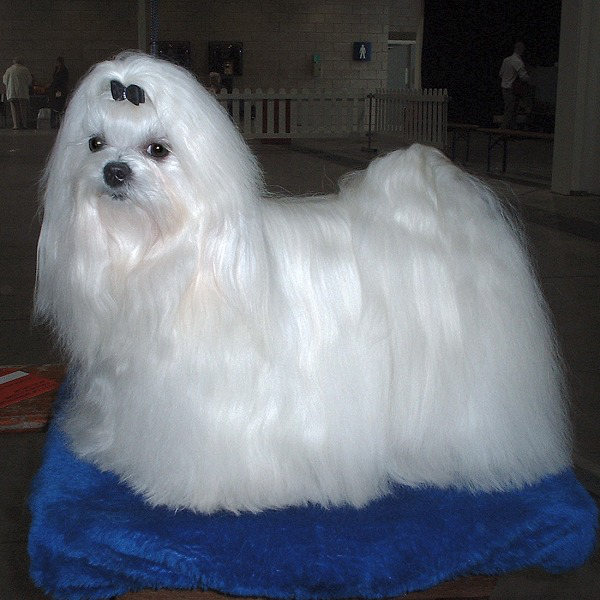

In [2]:
image_path = tf.keras.utils.get_file("good_boy.jpg", "https://raw.githubusercontent.com/MajusLenz/Dogspiracy-machine-learning/master/data/images/predict/good_boy.jpg")
Image.open(image_path)


Das Bild wird in Tensorflow Format konvertiert:

In [3]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

Über eine Funktion kann das Originalbild mit dem augmentierten Bild verglichen werden:

In [4]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


Das Bild spiegeln:

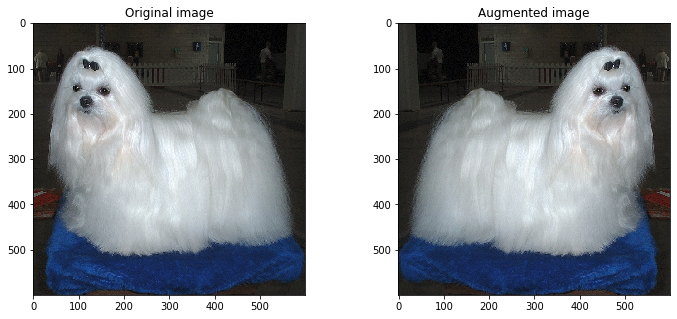

In [5]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

Saturation

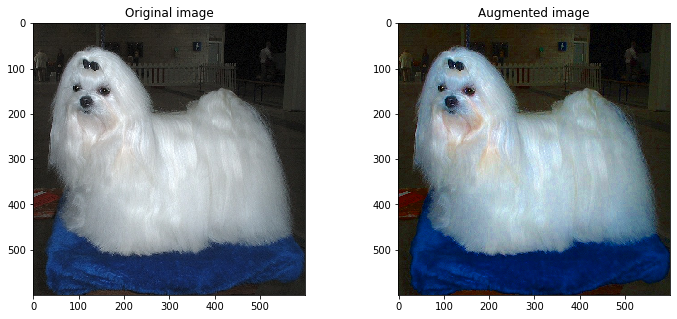

In [6]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)


Helligkeit:

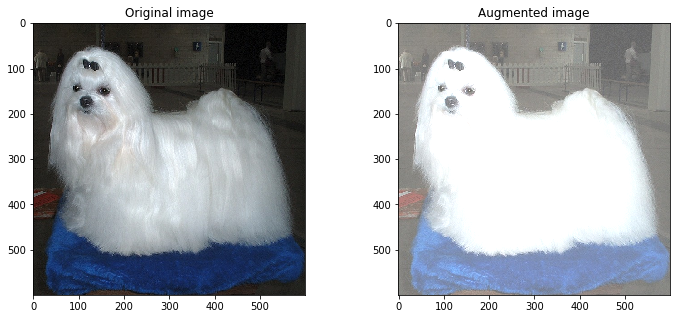

In [7]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

Kontrast:

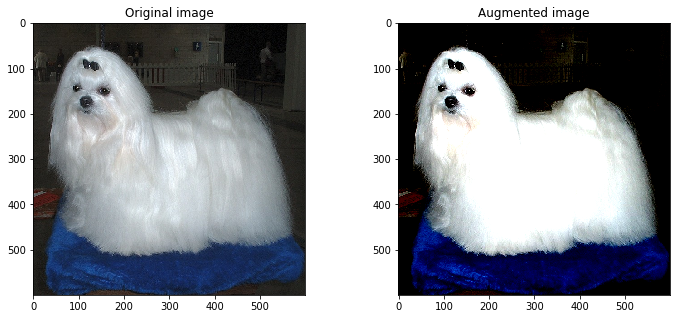

In [8]:
contrast = tf.image.adjust_contrast(image, 2)
visualize(image, contrast)

Rotation

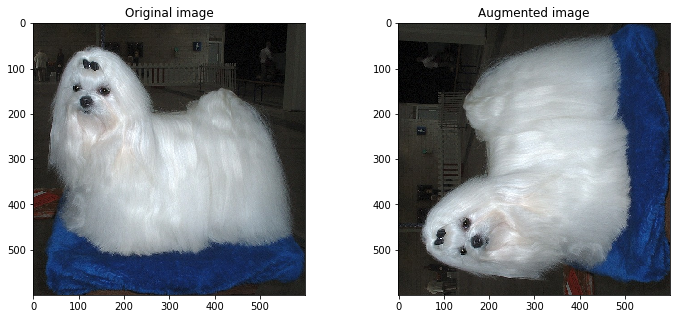

In [9]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

Crop

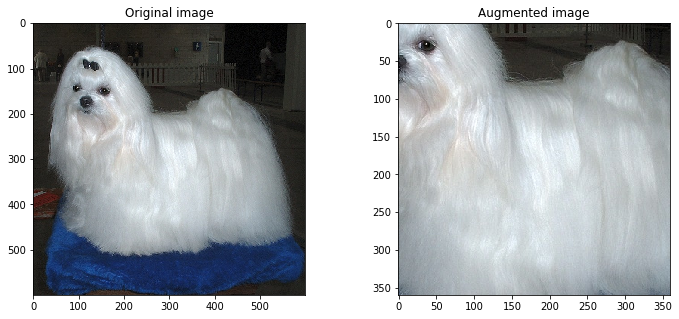

In [10]:
cropped = tf.image.central_crop(image, central_fraction=0.6)
visualize(image,cropped)


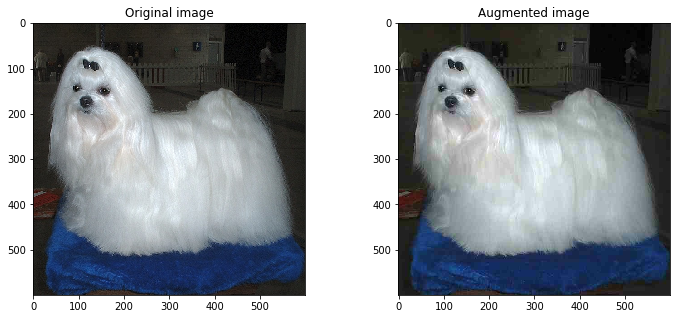

In [11]:
quality = tf.image.adjust_jpeg_quality(image, 20)
visualize(image,quality)

## Image Augmentation am Beispiel vom MNIST Datensatz

In diesem Abschnitt wird der MNIST-Datensatz mit handgeschriebene Ziffern verwendet. MNIST enthält einen Trainingsdatensatz mit 60.000 Bildern und einen Testdatensatz mit 10.000 Bildern. Die Ziffern wurden größennormalisiert und in einem Bild mit fester Größe zentriert.

_"It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting."_ 

[MINST Webseite](http://yann.lecun.com/exdb/mnist/) 

Im Kontext des Jupyter Nodebooks wurde sich deshalb entschieden diesen Datensatz zu verwenden, um eine schnelle Ausführbarkeit und Experimentieren mit Parametern zu ermöglichen. Über das Package _tensorflow_datasets_ gibt es die Möglichkeit vorgefertigte Datensets herunterzuladen.

Im folgenden wird das Datenset geladen und die Form des Datensatzes ausgegeben:

In [12]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

print("Größe des Trainingsdatensatzes: "+ str(info.splits['train'].num_examples))
print("Größe des Testdatensatzes: "+ str(info.splits['test'].num_examples))
print(info.features['image'])
print(info.features['label'])

Größe des Trainingsdatensatzes: 60000
Größe des Testdatensatzes: 10000
Image(shape=(28, 28, 1), dtype=tf.uint8)
ClassLabel(shape=(), dtype=tf.int64, num_classes=10)


Aus den Ziffern 0 bis 9 ergeben sich 10 Klassen. Die Bilder haben die Form 28x28 Pixel und sind in Graustufen.

### Augmentierung

Da die Bilder des MNIST Datensatzen in Graustufen vorliegen, ergibt es keinen Sinn random_saturation zu nutzen. Außerdem sollte auch Spiegelung (flip_left_right) nicht eingesetzt werden, da das CNN sonst gespiegelte Zahlen lernt. 

In [13]:
def augment(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    
  return image,label

### Vorbereitung des Trainings 

Die Pixel der Bilder liegen in einem Wertebereich von 0 bis 255 (Graustufen). Über eine Hilfsmethode werden die Bilder zu Floatwerten konvertiert und in einen Wertebereich von [0,1] gebracht, also normalisiert. Um Overfitting zu erzeugen wird nur ein Subset des Datensets zum Trainieren verwendet.

In [14]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

BATCH_SIZE = 64
NUM_SUBSET = 2048

augmented_train_batches = (
    train_dataset
    .take(NUM_SUBSET)
    .cache()
    .shuffle(num_train_examples//4)
    .map(augment, num_parallel_calls=AUTOTUNE) # mit Augmentation
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

non_augmented_train_batches = (
    train_dataset
    .take(NUM_SUBSET)
    .cache()
    .shuffle(num_train_examples//4)
    .map(convert, num_parallel_calls=AUTOTUNE) # ohne Augmentation
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

### Model

Um Overfitting zu erzeugen und Image Augmentation als Maßnahme gegen Overfitting einzusetzen, wird ein Model ohne Convolutional (Conv2D) Layer mit nur zwei Schichten erzeugt. 


Um den Einfluss der Image Augmentation besser sichtbar zu machen, wurde das Model so rudimentär wie möglich gelassen und haben bewusst keine anderen Methoden zur vermeidung von Overfitting genutzt, wie Dropout Layers oder Kernel Initializer.

In [15]:
def new_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

### Training im Vergleich

In [16]:
model_without_aug = new_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=5, validation_data=validation_batches)

model_with_aug = new_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/5
32/32 [==============================] - 20s 630ms/step - loss: 0.7855 - accuracy: 0.7720 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 17s 530ms/step - loss: 0.1907 - accuracy: 0.9434 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
32/32 [==============================] - 17s 544ms/step - loss: 0.1116 - accuracy: 0.9648 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/5
32/32 [==============================] - 18s 557ms/step - loss: 0.0472 - accuracy: 0.9839 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/5
32/32 [==============================] - 18s 566ms/step - loss: 0.0353 - accuracy: 0.9888 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 1/5
32/32 [==============================] - 22s 697ms/step - loss: 2.3702 - accuracy: 0.2944 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 18s 550ms/step - loss: 1.3799 - accuracy: 0.5269 

Um die Ergebnisse besser vergleichen zu können, werden Trainings- und Validierungsverläufe als Diagramm geplottet:

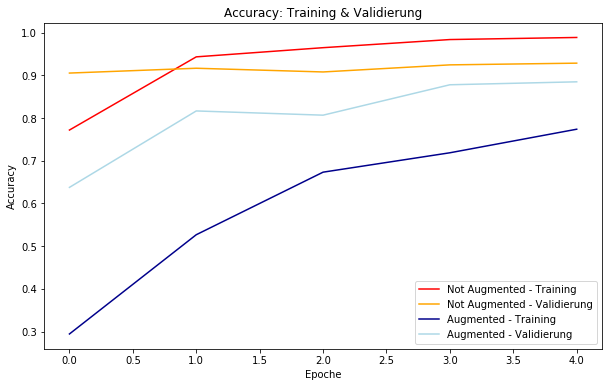

In [17]:
plt.figure(figsize = (10, 6))
plt.plot(range(5), no_aug_history.history["accuracy"], "red", label = "Not Augmented - Training")
plt.plot(range(5), no_aug_history.history["val_accuracy"], "orange", label = "Not Augmented - Validierung")
plt.plot(range(5), aug_history.history["accuracy"], "darkblue", label = "Augmented - Training")
plt.plot(range(5), aug_history.history["val_accuracy"], "lightblue", label = "Augmented - Validierung")
plt.title("Accuracy: Training & Validierung")
plt.ylabel("Accuracy")
plt.xlabel("Epoche")
plt.legend()
plt.show()

plt.figure(figsize = (10, 6))
plt.plot(range(5), no_aug_history.history["loss"], "red", label = "Not Augmented - Training")
plt.plot(range(5), no_aug_history.history["val_loss"], "orange", label = "Not Augmented - Validierung")
plt.plot(range(5), aug_history.history["loss"], "darkblue", label = "Augmented - Training")
plt.plot(range(5), aug_history.history["val_loss"], "lightblue", label = "Augmented - Validierung")
plt.title("Loss: Training & Validierung")
plt.ylabel("Verlustfunktion")
plt.xlabel("Epoche")
plt.legend()
plt.show()

## Schlussteil <div id="schluss" />

TODO: auch ca. 50 Epochen nutzen. Dann können wir die Aussage treffen, dass die Accuracy gegen einen bestimmten Wert konvergiert. Und einen richtigen Vergleich ziehen.

## Quellenverzeichnis <div id="quellen" />
- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
- https://www.tensorflow.org/tutorials/images/data_augmentation
- https://www.tensorflow.org/datasets/overview
- http://yann.lecun.com/exdb/mnist/